In [1]:
%load_ext autoreload
%autoreload 2
import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 0 1 7

#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".70"
import numpy as np
from src.datasets.loaders import load_dataset, BootstrapLoader
from src.models.models import DML, EnsembleRegressor, RPNEnsembleRegressor, EnsembleCustomJNN
from jax import random

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from jax import numpy as jnp
import random as orandom

# Jax NN Approach

In [2]:
train, out = load_dataset("Synthetic4BookChap.csv", normalize=False, frac=0, years=[2003, 2004, 2005, 2006, 2007])
EV_train1, RECO_train1, driver_train, RECO_max_abs = out
indices = np.array(~np.isnan(RECO_train1) * np.prod(~np.isnan(EV_train1), axis=1) * ~np.isnan(driver_train), dtype=bool)

for i in reversed(range(9)):
    results = pd.DataFrame(columns=['Q', 'Q_upper', 'Q_lower'])
    n_samples = 2 ** i * 100
    n_bootstrapsamples = 100

    try:
        results = pd.read_csv(Path.cwd().parent.joinpath('results', 'Q10s_2', f'Q10_JNN_{n_samples}_no_reg.csv'))
        Qs_mean = list(results['Q'].values)
        Qs_upper = list(results['Q_upper'].values)
        Qs_lower = list(results['Q_lower'].values)
        start = len(results)
    except:
        Qs_mean = list()
        Qs_upper = list()
        Qs_lower = list()
        start = 0

    Qs_mean = list()
    Qs_upper = list()
    Qs_lower = list()

    orandom.seed(i)
    rng_keys1 = orandom.sample(range(1000000), n_bootstrapsamples)
    rng_keys2 = orandom.sample(range(1000000), n_bootstrapsamples)
    rng_keys3 = orandom.sample(range(1000000), n_bootstrapsamples)

    model_config = {"layers": [2,16,16,1],
                    "dropout_p": 0.0,
                    "ensemble_size": 1}

    trainer_config = {"weight_decay": 0.0}
    config = {
        'ml_m': 'EnsembleCustomJNN',
        'ml_m_config': {'model_config': model_config,
                        'trainer_config': trainer_config,
                        },
        'ml_l': 'EnsembleCustomJNN',
        'ml_l_config': {'model_config': model_config,
                        'trainer_config': trainer_config,
                        },
    
        'dml_config': dict(dml_procedure = 'dml2',
                        score = 'partialling out',
                        n_folds = 10,
                        n_rep = 1)}

    for j in range(start, 50):
        results = pd.DataFrame(columns=['Q', 'Q_upper', 'Q_lower'])
        seed = rng_keys1[j]
        orandom.seed(seed)
        np.random.seed(seed)
        
        bootstrapsample = np.random.choice(np.arange(len(indices))[indices], size=n_samples, replace=True)
        bootstrapsample.sort()

        X = EV_train1[bootstrapsample]
        T = driver_train[bootstrapsample]
        y = RECO_train1[bootstrapsample]

        config['seed'] = rng_keys2[j]
        inputs = {'T': T, 'EV': X}
        dml = DML(config)
        dml.fit(inputs, y)
        
        Qs_mean.append(dml.Q10_mean)
        Qs_lower.append(dml.Q10_std_lower)
        Qs_upper.append(dml.Q10_std_upper)
    
        results['Q'] = Qs_mean
        results['Q_lower'] = Qs_lower
        results['Q_upper'] = Qs_upper

        #results.to_csv(Path.cwd().parent.joinpath('results', 'Q10s_2', f'Q10_JNN_{n_samples}_no_reg.csv'))

 73%|███████▎  | 1456/2000 [00:05<00:02, 251.26it/s, Max loss=0.037475444, Max test loss=0.0546354, Best test loss=0.04933404]  


KeyboardInterrupt: 

# RFApproach

In [3]:
    results = pd.read_csv(Path.cwd().parent.joinpath('results', 'Q10s_2', f'Q10_RF_{51200}_no_reg.csv'))


In [12]:
len(results)

2

In [13]:
train, out = load_dataset("Synthetic4BookChap.csv", normalize=False, frac=0, years=[2003, 2004, 2005, 2006, 2007])
EV_train1, RECO_train1, driver_train, RECO_max_abs = out
indices = np.array(~np.isnan(RECO_train1) * np.prod(~np.isnan(EV_train1), axis=1) * ~np.isnan(driver_train), dtype=bool)
n_bootstrapsamples = 100

for i in reversed(range(10)):
    results = pd.DataFrame(columns=['Q', 'Q_upper', 'Q_lower'])
    n_samples = 2 ** i * 100

    try:
        results = pd.read_csv(Path.cwd().parent.joinpath('results', 'Q10s_2', f'Q10_RF_{n_samples}_no_reg.csv'))
        Qs_mean = list(results['Q'].values)
        Qs_upper = list(results['Q_upper'].values)
        Qs_lower = list(results['Q_lower'].values)
        start = len(results)
    except:
        Qs_mean = list()
        Qs_upper = list()
        Qs_lower = list()
        start = 0

    orandom.seed(i)
    rng_keys1 = orandom.sample(range(1000000), n_bootstrapsamples)
    rng_keys2 = orandom.sample(range(1000000), n_bootstrapsamples)
    rng_keys3 = orandom.sample(range(1000000), n_bootstrapsamples)

    config = {
        'ml_m': 'RandomForestRegressor',
        'ml_m_config': {'n_estimators':100},#"n_estimators": 100, 
                        #"max_features": 2, 
                        #"max_depth": 5, 
                        #"min_samples_leaf": 2},
                        
        'ml_l': 'RandomForestRegressor',
        'ml_l_config': {'n_estimators':100},
        'dml_config': dict(dml_procedure = 'dml2',
                        score = 'partialling out',
                        n_folds = 10,
                        n_rep = 1)}

    for j in range(start,50):
        results = pd.DataFrame(columns=['Q', 'Q_upper', 'Q_lower'])
        seed = rng_keys1[j]
        orandom.seed(seed)
        np.random.seed(seed)
        
        bootstrapsample = np.random.choice(np.arange(len(indices))[indices], size=n_samples, replace=True)
        bootstrapsample.sort()

        X = EV_train1[bootstrapsample]
        T = driver_train[bootstrapsample]
        y = RECO_train1[bootstrapsample]

        config['seed'] = rng_keys2[j]
        inputs = {'T': T, 'EV': X}
        dml = DML(config)
        dml.fit(inputs, y)
        
        Qs_mean.append(dml.Q10_mean)
        Qs_lower.append(dml.Q10_std_lower)
        Qs_upper.append(dml.Q10_std_upper)
    
        results['Q'] = Qs_mean
        results['Q_lower'] = Qs_lower
        results['Q_upper'] = Qs_upper

        results.to_csv(Path.cwd().parent.joinpath('results', 'Q10s_2', f'Q10_RF_{n_samples}_no_reg.csv'))

: 

: 

# Vanilla NN Approach

In [11]:
train, test, out = load_dataset("Synthetic4BookChap.csv", normalize=False, frac=0.2, years=[2003, 2004, 2005, 2006, 2007])
EV_train1, RECO_train1, driver_train, EV_test1, RECO_test1, driver_test, RECO_max_abs = out
indices = np.array(~np.isnan(RECO_train1) * np.prod(~np.isnan(EV_train1), axis=1) * ~np.isnan(driver_train), dtype=bool)
indices_test = np.array(~np.isnan(RECO_test1) * np.prod(~np.isnan(EV_test1), axis=1) * ~np.isnan(driver_test), dtype=bool)

X = EV_train1[indices]
T = driver_train[indices][:,None]
y = RECO_train1[indices][:,None]

X_test = EV_test1[indices_test]
T_test = driver_test[indices_test][:,None]
y_test = RECO_test1[indices_test][:,None]

data_val = [X_test, T_test, y_test]

for i in range(10):
    n_samples=2** i *100
    results = pd.DataFrame(columns=['Q'])

    rng_key = random.PRNGKey(i+11)
    rng_key, rng_key2, rng_key3 = random.split(rng_key, 3)

    dataset = BootstrapLoader(X, T, y, 256, 100, n_samples=n_samples, rng_key=rng_key)

    regressor = EnsembleRegressor([2, 16, 16, 1], 100, p=0.2, weight_decay=0.0, rng_key=rng_key2)
    regressor.fit(dataset, data_val, nIter=2000, rng_key=rng_key3)
    sample, Rb, Q10 = regressor.posterior(X, T)
    results['Q'] = Q10[:,0]

    results.to_csv(Path.cwd().parent.joinpath('results', 'Q10s_2', f'Q10_vanilla_{n_samples}_reg.csv'))

100%|██████████| 2000/2000 [01:13<00:00, 27.37it/s, Max loss=0.0028207768, Max test loss=0.0033864623]


# Plots

In [47]:
results_NN = dict()
results_DML = dict()
results_lower = dict()
results_upper = dict()
results_RF = dict()


for i, n_samples in enumerate([100*2**i for i in range(10)]):
    dataframe = pd.read_csv(Path.cwd().parent.joinpath('results', 'Q10s_1', f'Q10_vanilla_{n_samples}.csv'))
    results_NN[n_samples] = dataframe['Q']
    
    try:
        dataframe = pd.read_csv(Path.cwd().parent.joinpath('results', 'Q10s_1', f'Q10_{n_samples}.csv'))
        results_DML[n_samples] = dataframe['Q']
        results_lower[n_samples] = dataframe['Q_lower']
        results_upper[n_samples] = dataframe['Q_upper']
    except:
        None       
    try:
        dataframe = pd.read_csv(Path.cwd().parent.joinpath('results', 'Q10s_1', f'Q10_RF_{n_samples}.csv'))
        results_RF[n_samples] = dataframe['Q']
    except:
        None       
    

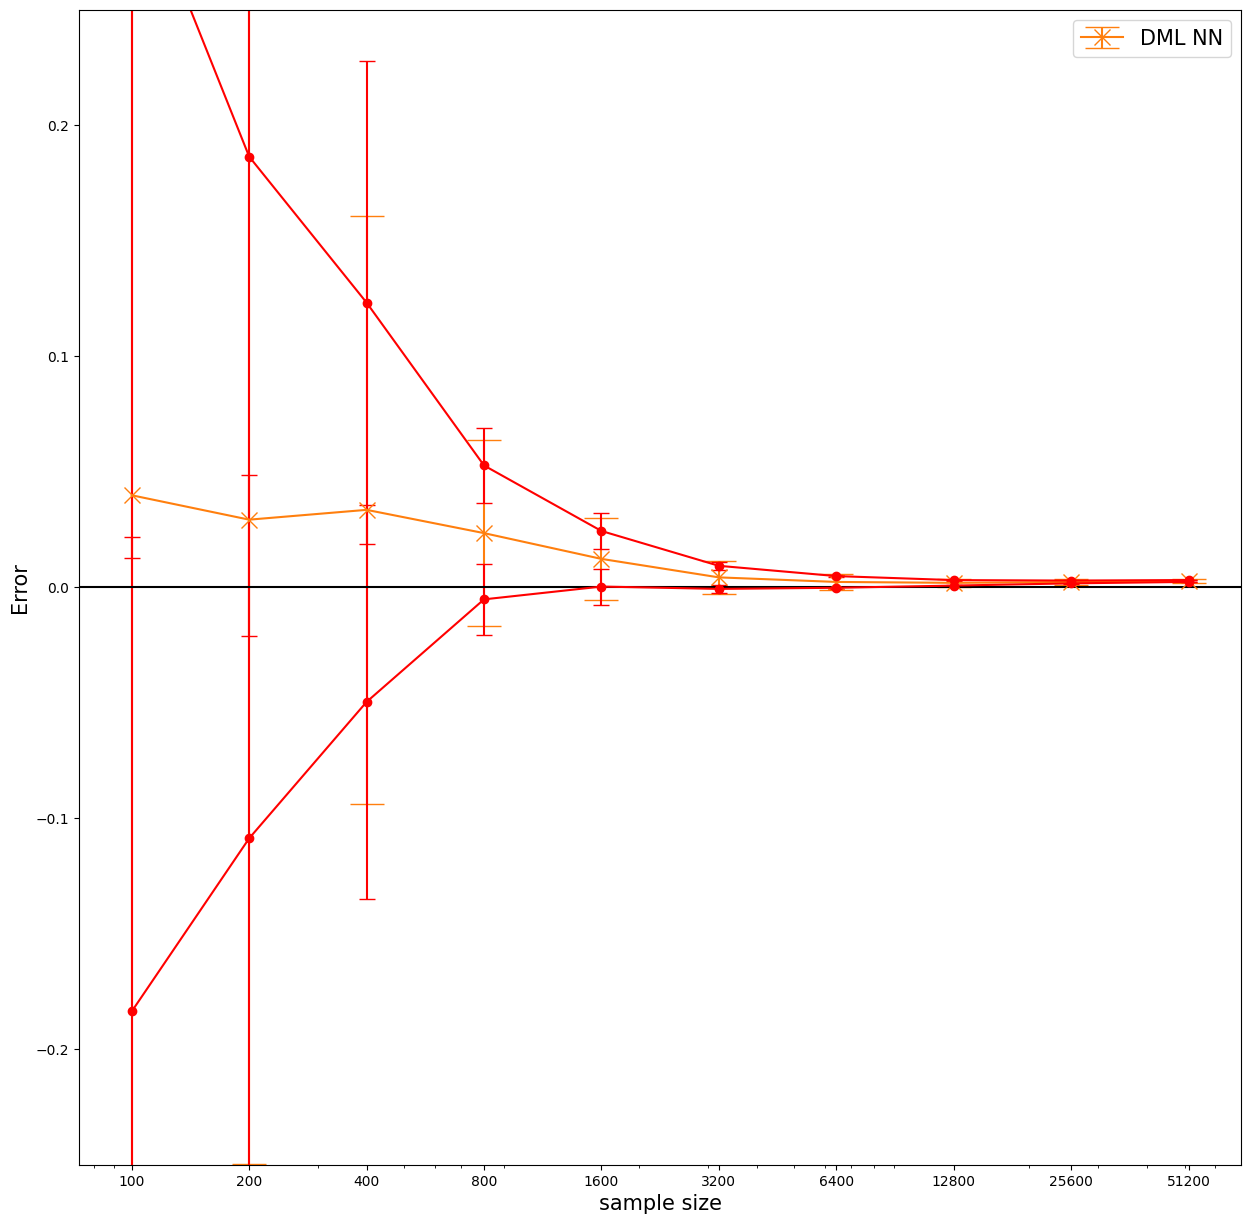

In [48]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
colors = ['tab:orange', 'tab:blue', 'tab:green']
lines = []
labels = ["DML NN", "Vanilla NN", 'DML RF']

keys_DML = np.array([int(x) for x in results_DML.keys()])
keys_DML.sort()
mean = 1.5-np.array([results_DML[key].mean() for key in keys_DML])
std = np.array([results_DML[key].std() for key in keys_DML])*1.96
std_est_lower = mean-np.array([results_lower[key].mean() for key in keys_DML])
std_est_lower_std = np.array([results_lower[key].std() for key in keys_DML])*1.96
std_est_upper = mean+np.array([results_upper[key].mean() for key in keys_DML])
std_est_upper_std = np.array([results_upper[key].std() for key in keys_DML])*1.96

keys_NN = np.array([int(x) for x in results_NN.keys()])
keys_NN.sort()
mean_2 = 1.5-np.array([results_NN[key].mean() for key in keys_NN])
std_2 = np.array([results_NN[key].std() for key in keys_NN])*1.96

keys_RF = np.array([int(x) for x in results_RF.keys()])
keys_RF.sort()
mean_3 = 1.5-np.array([results_RF[key].mean() for key in keys_RF])
std_3 = np.array([results_RF[key].std() for key in keys_RF])*1.96

    
line = ax.errorbar(keys_DML, mean, std, color = colors[0], marker='x', capsize=12, markersize="12", label = labels[0])
#line_2 = ax.errorbar(keys_NN, mean_2, std_2, color = colors[1], marker='x', capsize=12, markersize="12", label = labels[1])
#line_3 = ax.errorbar(keys_RF, mean_3, std_3, color = colors[2], marker='x', capsize=12, markersize="12", label = labels[2])
line_3 = ax.errorbar(keys, std_est_lower, std_est_lower_std, color = 'red', marker='.', capsize=6, markersize="12", label = 'lower')
line_4 = ax.errorbar(keys, std_est_upper, std_est_upper_std, color = 'red', marker='.', capsize=6, markersize="12", label = 'upper')


#ax.scatter(keys, mean+std_est_upper, marker='x', color='red', label='upper')
#ax.scatter(keys, mean-std_est_lower, marker='x', color='red', label='lower')

lines.append(line)
#lines.append(line_2)
#lines.append(line_3)
ax.set_ylim(-0.25,0.25)
ax.set_xscale('log')
ax.set_xticks(keys)
ax.set_xticklabels(keys, fontsize = 10)
ax.set_xlabel('sample size', fontsize=15)
ax.set_ylabel('Error', fontsize=15)
ax.axhline(y=0, color='black', linestyle='-')
#ax.hlines(y = 0, xmin = np.exp(-5),xmax = np.exp(6), colors = ["black"])

ax.legend(lines, labels, fontsize=15)

In [8]:
regressor.Q10.mean(), regressor.Q10.std()

(Array(1.5010314, dtype=float32), Array(0.00182417, dtype=float32))

<Axes: ylabel='Density'>

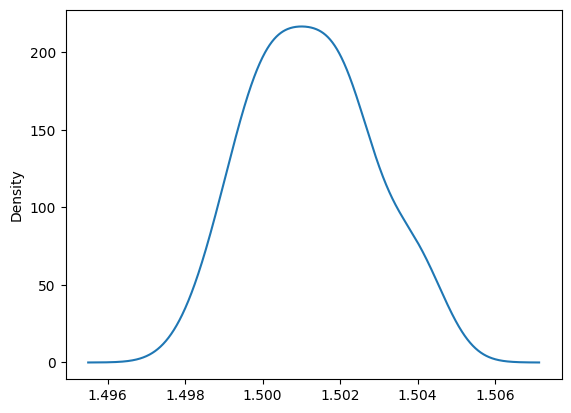

In [9]:
pd.Series(Q10.reshape(-1)).plot(kind="density")


# Bayesian Neural Network HMC